<a href="https://colab.research.google.com/github/AmirAzz/Test/blob/main/TAKEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Thu Mar 30 13:38:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
%cd {HOME}
!git clone https://github.com/WongKinYiu/yolov7
%cd {HOME}/yolov7
!pip install -r requirements.txt

/content
Cloning into 'yolov7'...
remote: Enumerating objects: 1139, done.
remote: Total 1139 (delta 0), reused 0 (delta 0), pack-reused 1139
Receiving objects: 100% (1139/1139), 70.31 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (514/514), done.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00


In [5]:
import sys
sys.path.append(f"{HOME}/yolov7")

In [6]:
%cd {HOME}
!mkdir input
%cd {HOME}/input

/content
/content/input


In [51]:
SOURCE_VIDEO_A_PATH = f"{HOME}/input/test.mp4"

In [52]:
SOURCE_VIDEO_A_PATH

'/content/input/test.mp4'

In [53]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])
    plt.show()

In [54]:
from typing import Optional, Tuple
from dataclasses import dataclass


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)
    

@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)
    
    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)
        
@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None
        
        
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

In [55]:
import cv2

import numpy as np

def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

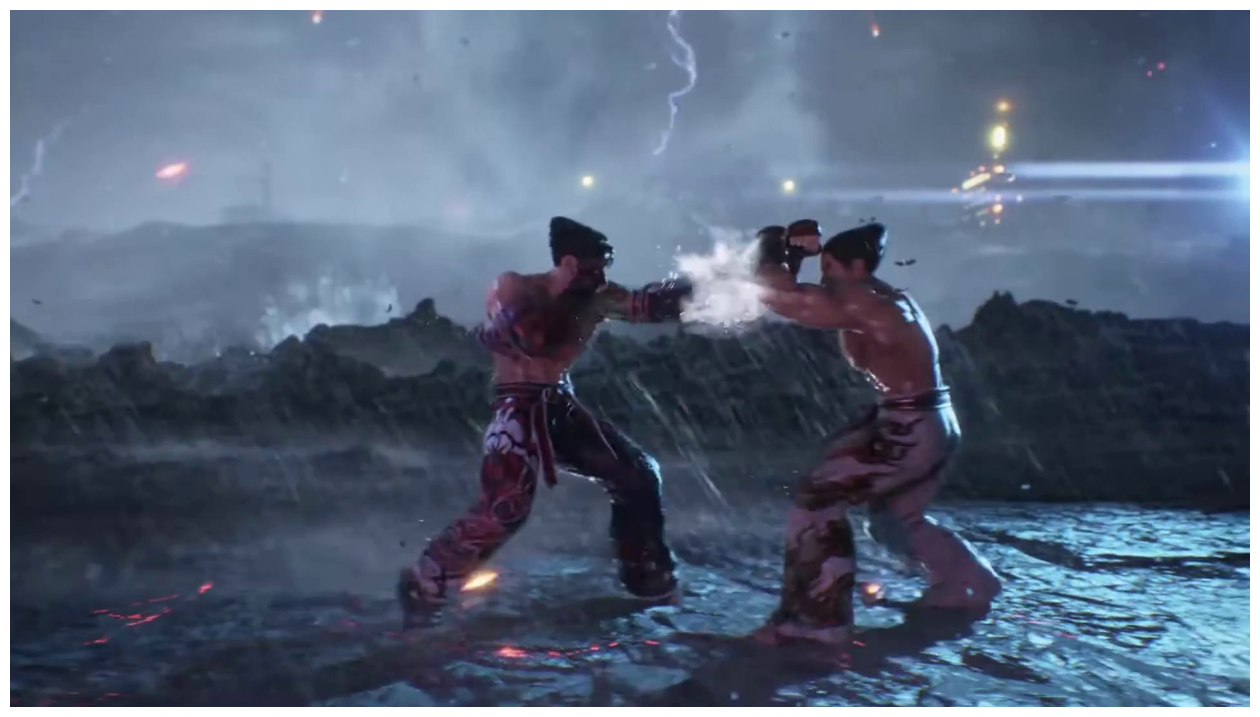

In [56]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)
plot_image(frame, 16)

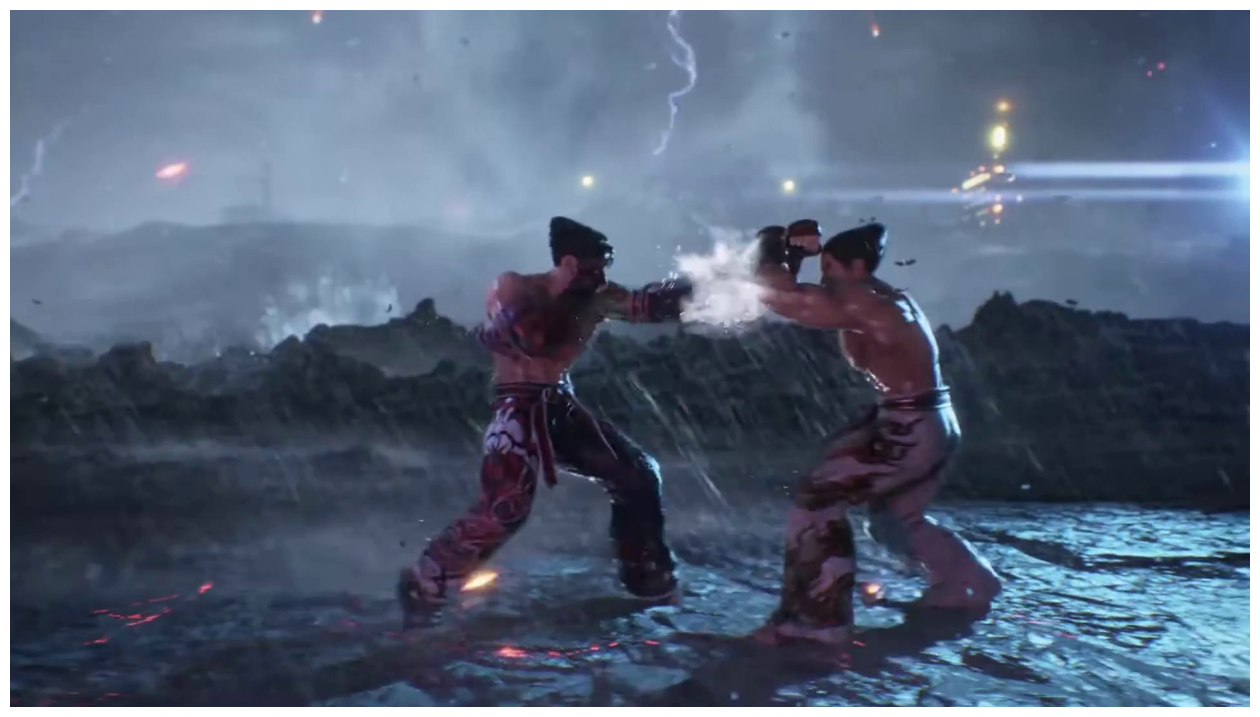

In [57]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

try:
    frame = next(frame_iterator)
    plot_image(frame, 16)
except StopIteration:
    print("Iteration is complete")


In [58]:
%cd {HOME}/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt --quiet
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt --quiet

/content/yolov7


In [59]:
DETECTION_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-e6e.pt"
POSE_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-w6-pose.pt"

In [60]:

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
from utils.general import check_img_size
from models.experimental import attempt_load

detection_model = attempt_load(weights=DETECTION_MODEL_WEIGHTS_PATH, map_location=device)

Fusing layers... 


In [62]:
weigths = torch.load(POSE_MODEL_WEIGHTS_PATH, map_location=device)
pose_model = weigths["model"]
_ = pose_model.float().eval()

if torch.cuda.is_available():
    pose_model.half().to(device)

In [63]:
DETECTION_IMAGE_SIZE = 1920
POSE_IMAGE_SIZE = 960
STRIDE = 64
CONFIDENCE_TRESHOLD = 0.25
IOU_TRESHOLD = 0.65

In [64]:
from utils.datasets import letterbox
from torchvision import transforms

import numpy as np


def detection_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    img = letterbox(frame, DETECTION_IMAGE_SIZE, STRIDE, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

def pose_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    image = letterbox(frame, POSE_IMAGE_SIZE, stride=STRIDE, auto=True)[0]
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))

    if torch.cuda.is_available():
        image = image.half().to(device)

    return image

In [65]:
from typing import Tuple

from utils.general import non_max_suppression_kpt, non_max_suppression
from utils.plots import output_to_keypoint

import numpy as np


def clip_coords(boxes: np.ndarray, img_shape: Tuple[int, int]):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0] = np.clip(boxes[:, 0], 0, img_shape[1]) # x1
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img_shape[0]) # y1
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img_shape[1]) # x2
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img_shape[0]) # y2


def detection_post_process_output(
    output: torch.tensor, 
    confidence_trashold: float, 
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold
    )
    coords = output[0].detach().cpu().numpy()
    
    v_gain = scaled_image_size[0] / image_size[0]
    h_gain = scaled_image_size[1] / image_size[1]

    coords[:, 0] /= h_gain
    coords[:, 1] /= v_gain
    coords[:, 2] /= h_gain
    coords[:, 3] /= v_gain

    clip_coords(coords, image_size)
    return coords


def post_process_pose(pose: np.ndarray, image_size: Tuple, scaled_image_size: Tuple) -> np.ndarray:
    height, width = image_size
    scaled_height, scaled_width = scaled_image_size
    vertical_factor = height / scaled_height
    horizontal_factor = width / scaled_width
    result = pose.copy()
    for i in range(17):
        result[i * 3] = horizontal_factor * result[i * 3]
        result[i * 3 + 1] = vertical_factor * result[i * 3 + 1]
    return result


def pose_post_process_output(
    output: torch.tensor, 
    confidence_trashold: float, 
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression_kpt(
        prediction=output, 
        conf_thres=confidence_trashold, 
        iou_thres=iou_trashold, 
        nc=pose_model.yaml['nc'], 
        nkpt=pose_model.yaml['nkpt'], 
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

        for idx in range(output.shape[0]):
            output[idx, 7:] = post_process_pose(
                output[idx, 7:], 
                image_size=image_size,
                scaled_image_size=scaled_image_size
            )

    return output

In [66]:
from utils.plots import plot_skeleton_kpts


def detect_annotate(image: np.ndarray, detections: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    annotated_image = image.copy()
    for x_min, y_min, x_max, y_max, confidence, class_id in detections:
        rect = Rect(
            x=float(x_min),
            y=float(y_min),
            width=float(x_max - x_min),
            height=float(y_max - y_min)
        )
        annotated_image = draw_rect(image=annotated_image, rect=rect, color=color, thickness=thickness)
    
    return annotated_image


def pose_annotate(image: np.ndarray, detections: np.ndarray) -> np.ndarray:
    annotated_frame = image.copy()

    for idx in range(detections.shape[0]):
        pose = detections[idx, 7:].T
        plot_skeleton_kpts(annotated_frame, pose, 3)

    return annotated_frame

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


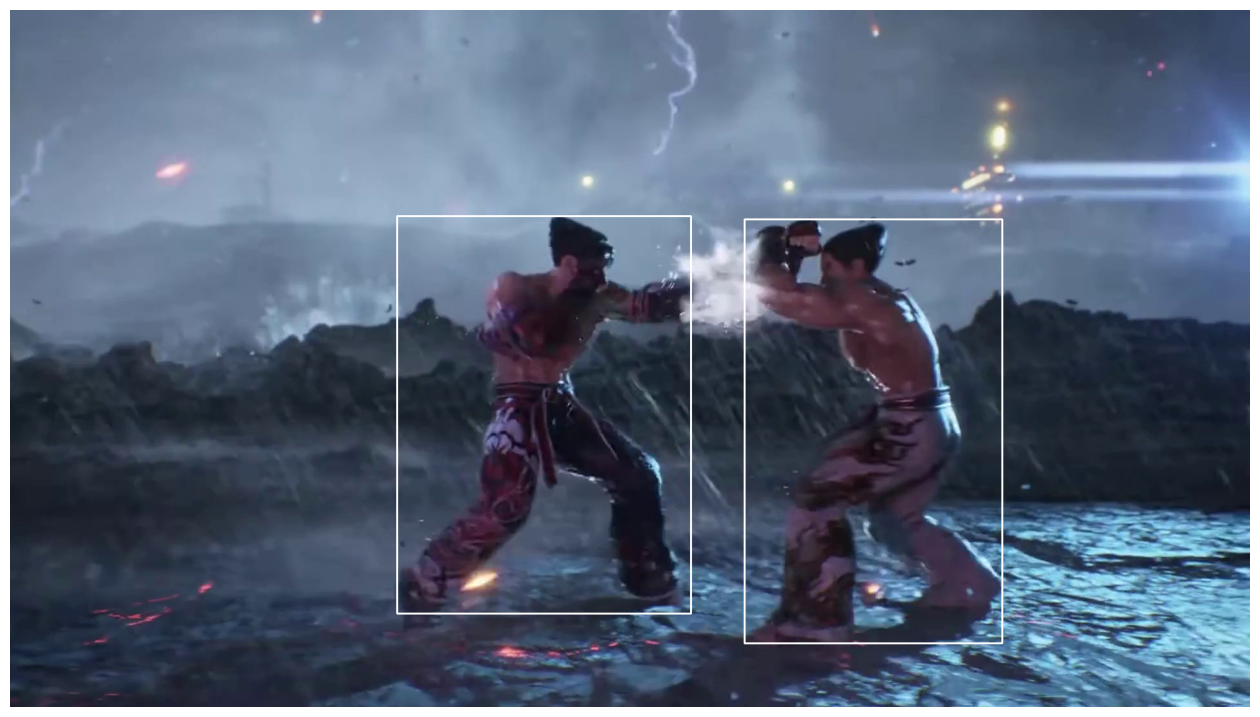

In [67]:
COLOR = Color(r=255, g=255, b=255)

frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

detection_pre_processed_frame = detection_pre_process_frame(
    frame=frame, 
    device=device
)

image_size = frame.shape[:2]
scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

with torch.no_grad():

    detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()

    detection_output = detection_post_process_output(
        output=detection_output,
        confidence_trashold=CONFIDENCE_TRESHOLD,
        iou_trashold=IOU_TRESHOLD,
        image_size=image_size,
        scaled_image_size=scaled_image_size
    )

annotated_frame = detect_annotate(image=frame, detections=detection_output, color=COLOR)

plot_image(annotated_frame, 16)

In [68]:
def process_frame_and_annotate(frame: np.ndarray) -> np.ndarray:
    pose_pre_processed_frame = pose_pre_process_frame(frame=frame.copy(), device=device)
    
    image_size = frame.shape[:2]
    scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]
    
    with torch.no_grad():
        pose_output, _ = pose_model(pose_pre_processed_frame)
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD, 
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=scaled_image_size
        )

    annotated_frame = pose_annotate(image=frame, detections=pose_output)

    return annotated_frame

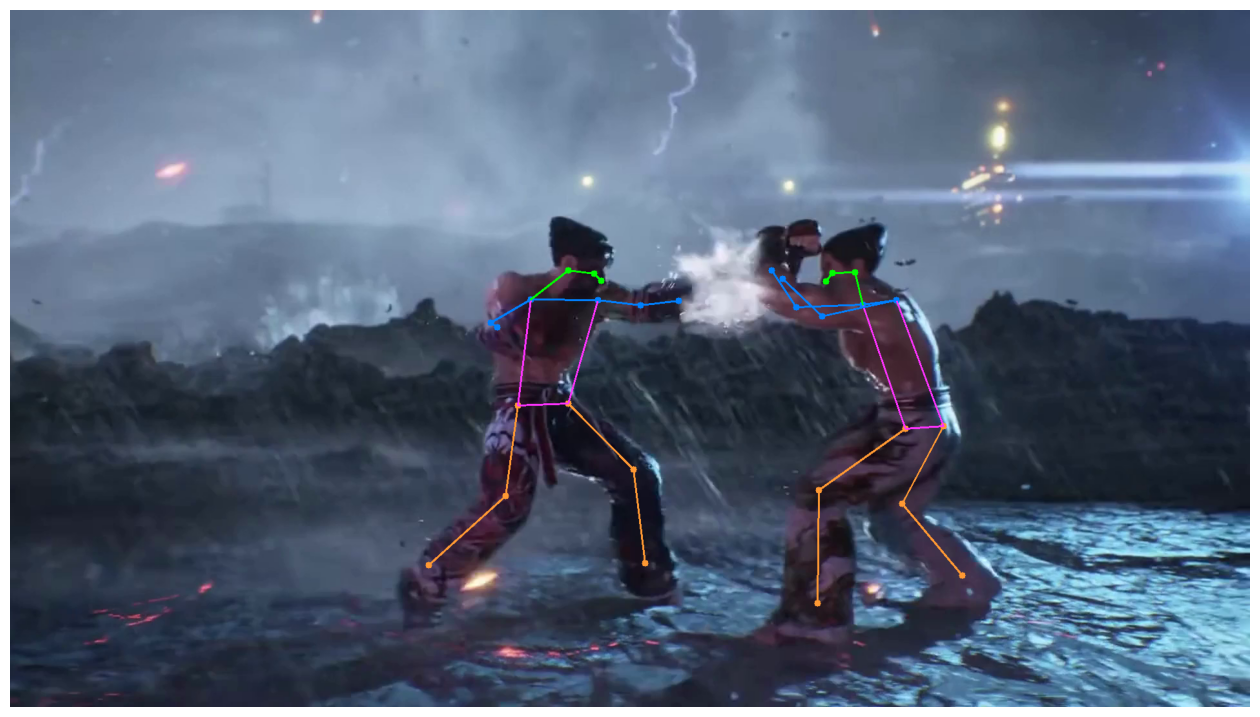

In [69]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

annotated_frame = process_frame_and_annotate(frame=frame)

plot_image(annotated_frame, 16)

In [70]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)
    
video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int
        

# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(SOURCE_VIDEO_A_PATH)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [71]:
SOURCE_VIDEO_PATH = SOURCE_VIDEO_A_PATH
TARGET_VIDEO_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-b.mp4"

In [72]:
from tqdm.notebook import tqdm

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=25, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

total = get_frame_count(SOURCE_VIDEO_PATH)

for frame in tqdm(frame_iterator, total=total):
    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame, 
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame, 
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD, 
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)

        # save video frame
        video_writer.write(annotated_frame)

# close output video
video_writer.release()

  0%|          | 0/891 [00:00<?, ?it/s]